In [1]:
import numpy as np
import pandas as pd
import tqdm
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy import ndimage as ndi
import cv2
import os
import seaborn as sns

%config Completer.use_jedi = False

In [2]:
train_dir = 'train_mod2'
test_dir = 'test_mod2'
a = pd.read_csv('annotations.csv', index_col=False)
a.filepath = a.filepath.str.replace('train\\ER', train_dir, regex=False).str.replace('train\\NR', train_dir, regex=False)
a

,filepath,type,energy
0,train_mod2\-0.003018522635102272__CYGNO_60_40_...,ER,30
1,train_mod2\-0.0031084376387298107__CYGNO_60_40...,ER,3
2,train_mod2\-0.003241758095100522__CYGNO_60_40_...,ER,3
3,train_mod2\-0.0032767392694950104__CYGNO_60_40...,ER,10
4,train_mod2\-0.004240238573402166__CYGNO_60_40_...,ER,3
...,...,...,...
13399,train_mod2\3.1387999057769775__CYGNO_60_40_He_...,He,1
13400,train_mod2\3.140399932861328__CYGNO_60_40_He_N...,He,20
13401,train_mod2\3.1407999992370605__CYGNO_60_40_He_...,He,20
13402,train_mod2\3.1412999629974365__CYGNO_60_40_He_...,He,6


In [3]:
def gauss(image, sigma):
    image = ndi.gaussian_gradient_magnitude(image, sigma=sigma)
    image = ((image >= image.max())).astype(np.uint8)
    return image

In [4]:
kernel = np.ones(shape=(3,3))
nz, avg, std = [], [], []
gausses = {key: [] for key in (0.5, 1, 2, 3, 5, 10)}
quants = {key: [] for key in np.arange(0.1, 1, 0.1)}
for fp in tqdm.tqdm(a.filepath):
    img = cv2.imread(fp, 0)
    nz.append(np.count_nonzero(img))
    avg.append(img[(img>0)].mean())
    std.append(img[(img>0)].std())
    for sigma in gausses:
        gausses[sigma].append(np.count_nonzero(gauss(img, sigma=sigma)))
    for q in quants:
        quants[q].append(np.quantile(img[(img>0)], q))
train_ds = pd.DataFrame({'nz': nz, 'avg': avg, 'std': std})
for i, q in enumerate(quants):
    train_ds[f'q{i}'] = quants[q]
for i, s in enumerate(gausses):
    train_ds[f'gausses{i}'] = gausses[s]

100%|████████████████████████████████████████████████████████████████████████████| 13404/13404 [04:12<00:00, 53.12it/s]


<AxesSubplot:xlabel='gausses0', ylabel='Count'>

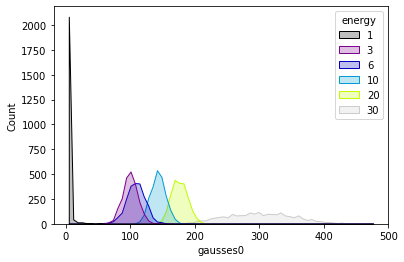

In [64]:
sns.histplot(x=train_ds['gausses0'], hue=a.energy, element='poly', palette='nipy_spectral')

In [5]:
def fit_cbc(X, y):
    model = CatBoostClassifier(random_seed=42, verbose=0)
    model.fit(X, y)
    return model

In [6]:
cols = train_ds.columns
cols

Index(['nz', 'avg', 'std', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7',
       'q8', 'gausses0', 'gausses1', 'gausses2', 'gausses3', 'gausses4',
       'gausses5'],
      dtype='object')

In [7]:
model_energy = fit_cbc(train_ds[cols], a['energy'].astype(str))
model_type = fit_cbc(train_ds[cols], a['type'].astype(str))

In [73]:
model_energy.save_model('saved_models\\cbc_energy2_gausses')
model_type.save_model('saved_models\\cbc_type2_gausses')